In [20]:
import awkward as ak
from pathlib import Path
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self['data'].fields:
            for i, bpm in enumerate(self['data'][crate]['ChannelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self['data'][crate]['Positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [3]:
bpms_path = Path('/Users/lisepauwels/sps_simulations/MD_data/20251010/bpms/')
data = ak.Array(ak.from_parquet(Path(bpms_path, '2025-10-10T12_50_10.parquet')),with_name='BPMCollection')

line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw_ref = line.twiss()

def get_bpm_in_line(bpm_name):
    return bpm_name if bpm_name != 'bph.41608' else 'bph.41607'

mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in data.bpms_hor])
mask_acq = np.array([False if len(np.unique(data.hor_turn_position[i]))==1 else True for i in range(len(data.bpms_hor))])
mask = (mask_bpm & mask_acq)

s_positions_bpms = []
for bpm in data.bpms_hor[mask]:
    s_positions_bpms.append(line.get_s_position(f'{get_bpm_in_line(bpm)}'))

s_positions_bpms = np.array(s_positions_bpms)

min_acq_number = np.min([len(bpm) for bpm in data.hor_turn_position])

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


Text(0, 0.5, 'Horizontal Turn Position [mm]')

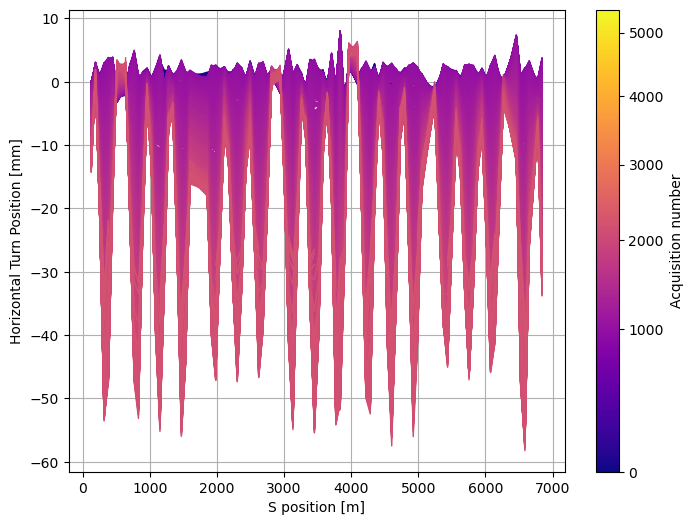

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=0, vmax=min_acq_number-1)
norm = colors.PowerNorm(gamma=0.7, vmin=0, vmax=min_acq_number - 1)
for i in range(min_acq_number):
    ax.plot(
        s_positions_bpms,
        data.hor_turn_position[mask][:, i],
        color=cmap(norm(i)),
        lw=1
    )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Acquisition number")
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

In [7]:
# TODO:
# - Actually b3 is not b3 but k2l :-)

# env = xt.load_madx_lattice('SPS_LS2_2025-10-14.seq')
# env.vars.load_madx('lhc_q20.str')

line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
env = line.env
env.vars.default_to_zero = False

env.vars.update(dict(
    b3a=-2.8e-03,# +/- 5.7e-04
    b3b=1.6e-03,# +/- 3.2e-04

    b5a=-7.9e+00,# +/- 5.4e-01
    b5b=-6.8e+00,# +/- 1.5e+00

    b7a=8.8e+04, # +/- 2.6e+04
    b7b=1.7e+05, # +/- 0.8e+05

    b3ar=0.0, #b3a*0.25,
    b3br=0.0, #b3b*0.25,

    b5ar=0.0, #b5a*0.25,
    b5br=0.0, #b5b*0.25,

    b7ar=0.0, #b7a*0.25,
    b7br=0.0, #b7b*0.25,
))

# line = env.sps
# line.particle_ref = xt.Particles(p0c=26e9, mass0=xt.PROTON_MASS_EV)

tw0 = line.twiss4d()

tt = line.get_table()
tt_bend = tt.rows[(tt.element_type=='Bend') | (tt.element_type=='RBend')]
tt_mba = tt_bend.rows['mba.*']
tt_mbb = tt_bend.rows['mbb.*']

# Generate random normal variables
np.random.seed(0)

env['on_error'] = 0

line.extend_knl_ksl(order=7, element_names=list(tt_mba.name) + list(tt_mbb.name))

for tt, family in zip([tt_mba, tt_mbb], ['a', 'b']):
    for order in [3, 5, 7]:
        rand_values = np.random.normal(0, 1, size=len(tt))
        for ii, nn in enumerate(tt_mba.name):
            new_expr = env.new_expr(
                f'(b{order}{family} + b{order}{family}r*{rand_values[ii]}) * on_error')
            env[nn].knl[order - 1] += new_expr

env['on_error'] = 0
tw_err_off = line.twiss4d()
env['on_error'] = 1
tw_err_on = line.twiss4d()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


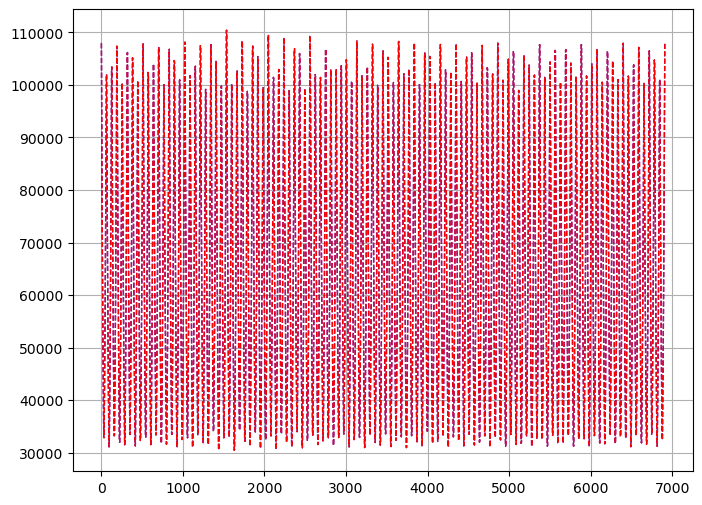

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

# ax.plot(tw0.s, tw0.betx * 1e3, '-', lw=1, color='black', label='Reference')
ax.plot(tw_err_off.s, tw_err_off.betx * 1e3, '--', lw=1, color='blue', label='Errors off')
ax.plot(tw_err_on.s, tw_err_on.betx * 1e3, '--', lw=1, color='red', label='Errors on')
ax.grid()

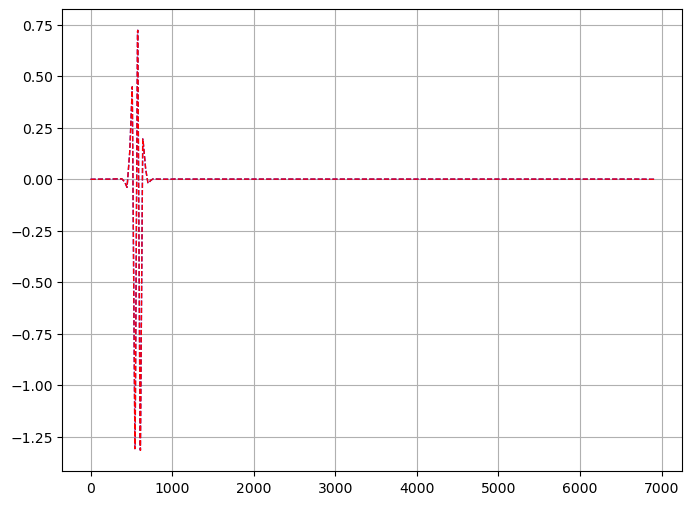

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

# ax.plot(tw0.s, tw0.betx * 1e3, '-', lw=1, color='black', label='Reference')
ax.plot(tw_err_off.s, tw_err_off.x * 1e3, '--', lw=1, color='blue', label='Errors off')
ax.plot(tw_err_on.s, tw_err_on.x * 1e3, '--', lw=1, color='red', label='Errors on')
ax.grid()

In [ ]:
def build_response_matrix(tw, monitor_names, corrector_names, plane=None):

    assert plane in ['x', 'y']

    # Build response matrix
    indices_monitors = tw.rows.indices[monitor_names]
    indices_correctors = tw.rows.indices[corrector_names]
    bet_monitors = tw['bet' + plane][indices_monitors]
    bet_correctors = tw['bet' + plane][indices_correctors]

    mu_monitor = tw['mu' + plane][indices_monitors]
    mux_correctors = tw['mu' + plane][indices_correctors]

    n_monitors = len(monitor_names)
    n_correctors = len(corrector_names)

    bet_prod = np.atleast_2d(bet_monitors).T @ np.atleast_2d(bet_correctors)
    mu_diff = (np.tile(mu_monitor, (n_correctors, 1)).T
                        - np.tile(mux_correctors, (n_monitors, 1)))

    # Slide 28
    # https://indico.cern.ch/event/1328128/contributions/5589794/attachments/2786478/4858384/linearimperfections_2024.pdf
    tune = tw['q' + plane]
    response_matrix = (np.sqrt(bet_prod) / 2 / np.sin(np.pi * tune)
                            * np.cos(np.pi * tune - 2*np.pi*np.abs(mu_diff)))

    return response_matrix

# """
#     Construct response matrix
#     """
#     response_matrix_H = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_H, 
#         corrector_names=errors_H, 
#         plane='x')
#     response_matrix_V = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_V, 
#         corrector_names=errors_V, 
#         plane='y')
    

#     """
#     Calculate necessary errors
#     """
#     U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
#     threshold_H = 1e-3 * np.max(sigma_H)
#     sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
#     M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
#     k_H = M_pseudo_inv_H @ target_val_H

#     U_V, sigma_V, VT_V = np.linalg.svd(response_matrix_V, full_matrices=False)
#     threshold_V = 1e-4 * np.max(sigma_V)
#     sigma_inv_V = np.array([1/s if s > threshold_V else 0 for s in sigma_V])
#     M_pseudo_inv_V = VT_V.T @ np.diag(sigma_inv_V) @ U_V.T
#     k_V = M_pseudo_inv_V @ target_val_V


# Turn-by-turn saving np.mean(part.x) and np.std(part.x)

In [17]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [18]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [19]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [22]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [23]:
num_particles = 1000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6